#Secondary structure prediction

## Set up

In [ ]:
import os

try:
    import nucleotide_transformer
except:
    !pip install numpy==1.23.5
    !pip install git+https://github.com/instadeepai/nucleotide-transformer@main |tail -n 1
    import nucleotide_transformer

if "COLAB_TPU_ADDR" in os.environ:
    from jax.tools import colab_tpu

    colab_tpu.setup_tpu()

!pip install -q biopython transformers datasets huggingface_hub accelerate
!pip install lightgbm

import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model

  Running command git clone --filter=blob:none --quiet https://github.com/instadeepai/nucleotide-transformer /tmp/pip-req-build-vpppingl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00


In [ ]:
#@title Select a model
#@markdown ---
model_name = '500M_human_ref'#@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species', '50M_multi_species_v2', '100M_multi_species_v2', '250M_multi_species_v2', '500M_multi_species_v2']
#@markdown ---

##Import model

In [ ]:
embeddings_layer = 20  # layer of embeddings extraction (0:24)
seq_max_length = 200  # Max length of the protein sequence

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    embeddings_layers_to_save=(embeddings_layer,),
    max_positions= 250
)
forward_fn = hk.transform(forward_fn)

##Import dataset

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset_dict = load_dataset("proteinea/secondary_structure_prediction")
dataset = dataset_dict["train"].to_pandas()

In [ ]:
def filter_dataset(dataset, seq_max_length):
    # making subsequences of length 100
    filtered_rows = []

    for index, row in dataset.iterrows():
        input_string = row["input"]
        dssp3_string = row["dssp3"]
        dssp8_string = row["dssp8"]

        x_positions = [pos for pos, char in enumerate(input_string) if char == 'X']
        o_positions = [pos for pos, char in enumerate(input_string) if char == 'O']

        if not (x_positions or o_positions):
            n = int(len(input_string)/seq_max_length) # Number of substrings created
            for i in range(n):
                start = i * seq_max_length
                stop = start + seq_max_length

                new_row = {
                    "input": input_string[start:stop],
                    "dssp3": dssp3_string[start:stop],
                    "dssp8": dssp8_string[start:stop]
                }

                filtered_rows.append(new_row)
        else:
            occurrences = sorted(x_positions + o_positions)

            start_idx = 0  # First non "X" or "O"
            for i in occurrences:
                if i - start_idx >= seq_max_length:
                    n = int((i - start_idx)/seq_max_length)
                    for j in range(n):
                        start = j*seq_max_length + start_idx
                        stop = start + seq_max_length

                        new_row = {
                            "input": input_string[start:stop],
                            "dssp3": dssp3_string[start:stop],
                            "dssp8": dssp8_string[start:stop]
                        }

                        filtered_rows.append(new_row)
                start_idx = i + 1

            # Check for the remaining substring at the end of the input string
            if len(input_string) - start_idx >= seq_max_length:
                n = int((len(input_string) - start_idx)/seq_max_length)
                for j in range(n):
                    start = j*seq_max_length + start_idx
                    stop = start + seq_max_length

                    new_row = {
                        "input": input_string[start:stop],
                        "dssp3": dssp3_string[start:stop],
                        "dssp8": dssp8_string[start:stop]
                    }

                    filtered_rows.append(new_row)


    df = pd.concat([pd.DataFrame([row]) for row in filtered_rows], ignore_index=True)
    return df

In [ ]:
df = filter_dataset(dataset, seq_max_length)

In [ ]:
df = df[:3000]  # Adjust to available memory

X_proteins = df["input"]
y_seq = df["dssp3"]  # Can be changed to "dssp8"

## Making amino acid sequences into dna sequences

In [ ]:
import random

def protein_to_rna(protein_sequence):
    amino_acid_to_codons = {
        "A": ["GCU", "GCC", "GCA", "GCG"],
        "R": ["CGU", "CGC", "CGA", "CGG", "AGA", "AGG"],
        "N": ["AAU", "AAC"],
        "D": ["GAU", "GAC"],
        "B": ["AAU", "AAC", "GAU", "GAC"],
        "C": ["UGU", "UGC"],
        "Q": ["CAA", "CAG"],
        "E": ["GAA", "GAG"],
        "Z": ["CAA", "CAG", "GAA", "GAG"],
        "G": ["GGU", "GGC", "GGA", "GGG"],
        "H": ["CAU", "CAC"],
        "I": ["AUU", "AUC", "AUA"],
        "L": ["CUU", "CUC", "CUA", "CUG", "UUA", "UUG"],
        "K": ["AAA", "AAG"],
        "M": ["AUG"],
        "F": ["UUU", "UUC"],
        "P": ["CCU", "CCC", "CCA", "CCG"],
        "S": ["UCU", "UCC", "UCA", "UCG", "AGU", "AGC"],
        "T": ["ACU", "ACC", "ACA", "ACG"],
        "W": ["UGG"],
        "Y": ["UAU", "UAC"],
        "V": ["GUU", "GUC", "GUA", "GUG"],
        "U": ["UGA"],
    }

    # Converts protein sequence to RNA sequence
    rna_sequence = ''
    for amino_acid in protein_sequence:
        codons = amino_acid_to_codons.get(amino_acid)
        rna_sequence += codons[random.randint(0, len(codons)-1)]  # Chose codon

    return rna_sequence

X_rna = [protein_to_rna(protein) for protein in X_proteins]

In [ ]:
def rna_to_dna(rna_sequence):
    rna_to_dna_base_pairs = {'A': 'T', 'U': 'A', 'C': 'G', 'G': 'C'}

    # Convert RNA sequence to complementary DNA sequence
    dna_sequence = ''.join(rna_to_dna_base_pairs.get(base) for base in rna_sequence)

    return dna_sequence

X_dna = [rna_to_dna(rna_sequence) for rna_sequence in X_rna]

##Tokenizing and retrieving embeddings

In [ ]:
batch_size = 8 # Adjust to available memory

def get_6mers_embeddings(sequences: list, batch_size: int):
    embeddings = []  # Stores 6mers embeddings

    # Split sequences into batches
    batched_sequences = [sequences[i:i + batch_size] for i in range(0, len(sequences), batch_size)]

    random_key = jax.random.PRNGKey(0)
    extraction_layer = "embeddings_" + str(embeddings_layer)
    cls_token_position = 0 # Position of the CLS token for every sequence

    for batch in batched_sequences:
        # Tokenize the batch
        tokens_ids = [b[1] for b in tokenizer.batch_tokenize(batch)]
        tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

        # Infer
        outs = forward_fn.apply(parameters, random_key, tokens)

        # Get embeddings
        batch_embeddings = outs[extraction_layer]

        # Mask for padding tokens
        padding_mask = (tokens != tokenizer.pad_token_id) & (jnp.arange(tokens.shape[1]) != cls_token_position)

        # Element-wise multiplication to set embeddings corresponding to padding tokens to zero
        masked_embeddings = batch_embeddings * padding_mask[:, :, None]

        # Removing embeddings relative to CLS and padding tokens
        sum_embeddings = jnp.sum(masked_embeddings, axis=-1)
        non_zero_mask = sum_embeddings != 0.0
        non_zero_embeddings = masked_embeddings[non_zero_mask]

        embeddings.append(non_zero_embeddings)


    return jnp.concatenate(embeddings, axis=0)

In [ ]:
X = get_6mers_embeddings(X_dna, batch_size)

In [ ]:
conc_y = ''.join(y_seq) # Concatenated sequences of target dna
y = [conc_y[i] + conc_y[i+1] for i in range(0, len(conc_y), 2)]  # Cartesian product of classes

In [ ]:
X2 = []
y2 = []
for i in range(0, len(X), 100):
    X2.append(X[i+10:i+90])
    y2.append(y[i+10:i+90])

X = jnp.concatenate(X2, axis=0)
%reset X2
y = [item for sublist in y2 for item in sublist]

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  x2, please run `%reset?` for details


## Storing embeddings - labels

In [ ]:
from google.colab import drive
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/data"

with open('/content/drive/My Drive/data/X.pkl', 'wb') as f: # Storing embeddings
  pickle.dump(X, f)

with open('/content/drive/My Drive/data/y.pkl', 'wb') as f: # Storing labels
  pickle.dump(y, f)

Mounted at /content/drive


## Downstream task

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
# Loading data from drive
with open('/content/drive/My Drive/data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('/content/drive/My Drive/data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

params = {
    'objective': 'multiclass',  # 'multiclass' for multi-class classification
    'metric': 'multi_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

clf = lgb.LGBMClassifier(**params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

def cartesian_accuracy_score(y_pred, y_test):
    y_pred = [char for string in y_pred for char in string]
    y_test = [char for string in y_test for char in string]
    return accuracy_score(y_test, y_pred)

# Evaluate the classifier's performance
accuracy = cartesian_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.794919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 160800, number of used features: 1280
[LightGBM] [Info] Start training from score -1.126977
[LightGBM] [Info] Start training from score -3.057555
[LightGBM] [Info] Start training from score -3.338818
[LightGBM] [Info] Start training from score -3.074635
[LightGBM] [Info] Start training from score -1.763905
[LightGBM] [Info] Start training from score -5.894347
[LightGBM] [Info] Start training from score -3.325412
[LightGBM] [Info] Start training from score -6.314593
[LightGBM] [Info] Start tr

## Prediction confusion matrix

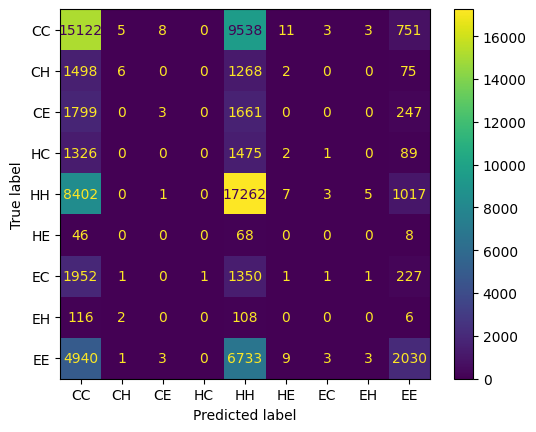

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels= ["CC", "CH", "CE", "HC", "HH", "HE", "EC", "EH", "EE"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CC", "CH", "CE", "HC", "HH", "HE", "EC", "EH", "EE"])
disp.plot()
plt.show()

## Testing model on training data

In [ ]:
train_pred = clf.predict(X_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


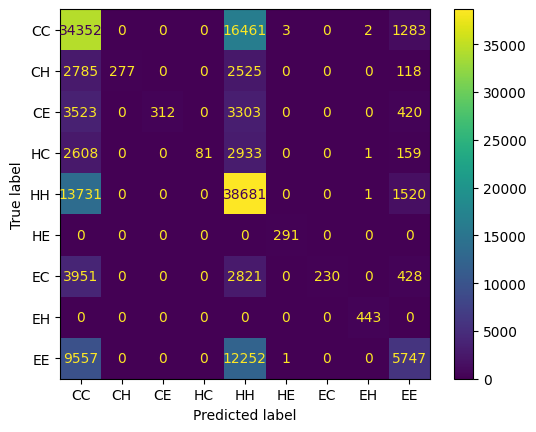

In [ ]:
cm2 = confusion_matrix(y_train, train_pred, labels= ["CC", "CH", "CE", "HC", "HH", "HE", "EC", "EH", "EE"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["CC", "CH", "CE", "HC", "HH", "HE", "EC", "EH", "EE"])
disp.plot()
plt.show()

In [ ]:
# Evaluate the classifier's performance
accuracy = cartesian_accuracy_score(y_train, train_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.56
